In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install timezonefinder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.9/993.9 kB 50.6 MB/s eta 0:00:00


In [ ]:
# for data handeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# for API handeling
import requests
import json
from datetime import datetime
from pytz import timezone
import timezonefinder

# for saving model
from joblib import Parallel, delayed
import joblib

In [ ]:
# loading the datasets
#root = "/content/gdrive/MyDrive/BTP sem7 Group 2/ropar_model/"

# root = '/content/gdrive/MyDrive/App_data/Copy of '

matdata = pd.read_csv("/content/gdrive/MyDrive/matdata.csv")
ropardata = pd.read_csv("/content/gdrive/MyDrive/ropar_data_final.csv")

<Axes: >

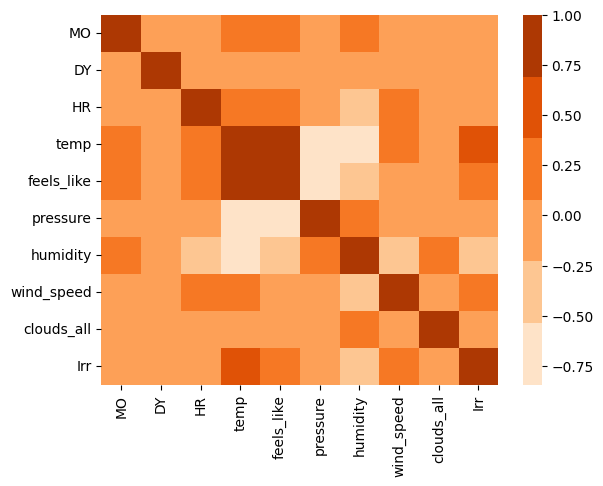

In [ ]:
correlation = ropardata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

<Axes: >

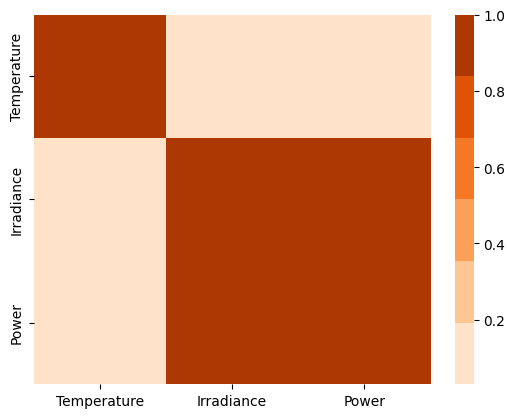

In [ ]:

correlation = matdata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

In [ ]:
# The below function will create the model, split the data, fit the model and checks the accuracies.
def model_maker(data,key):
    # creating the model.
    regressor = ExtraTreesRegressor(n_estimators = 20)

    # extracting X and Y from the data.
    df2 = data.iloc[:,:-1]
    X = df2.to_numpy()
    Y = data[key].to_numpy()

    # X_train and Y_train for training the model. X_test, Y_test for testing.
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=1)

    #fitting the model
    regressor.fit(X_train, Y_train)

    # Calcuting the accuracies
    accuracies = cross_val_score(estimator = regressor, X = X_train,y = Y_train, cv = 2, scoring = 'r2')
    accuracy = accuracies.mean()
    print('\n--------------------------------------------------\n')
    print('From Training Data:')
    print(f'r2 = {accuracy}\n')


    # predicting radiance and accuracy calculation
    y_pred = regressor.predict(X_test)
    explained_variance_score2 = explained_variance_score(Y_test, y_pred)
    mean_squared_error2 = mean_squared_error(Y_test, y_pred)
    r_squared = r2_score(Y_test, y_pred)


    print('From Testing Data:')
    print(f'explained variance = {explained_variance_score2}')
    print(f'mse = {mean_squared_error2}')
    print(f'r2 = {r_squared}')

    plt.plot(Y_test[:50])
    plt.plot(y_pred[:50])
    plt.legend(["Actual Data", "Predicted Data"])
    plt.show()
    print('\n--------------------------------------------------\n')
    return regressor


--------------------------------------------------

From Training Data:
r2 = 0.9946007066531596

From Testing Data:
explained variance = 0.9955200112378008
mse = 465.95767182417734
r2 = 0.9955170519308496


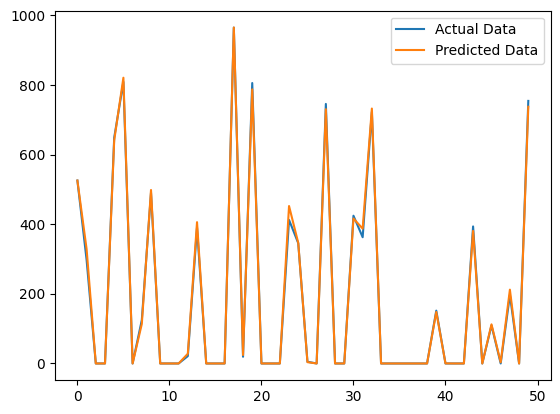


--------------------------------------------------


--------------------------------------------------

From Training Data:
r2 = 0.9502992997075923

From Testing Data:
explained variance = 0.9995142605510198
mse = 5.49406284000001
r2 = 0.9994271673399542


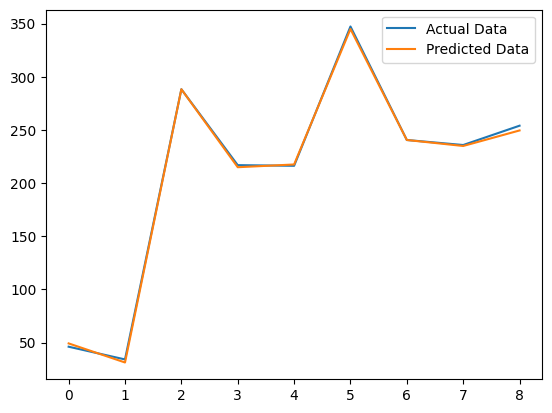


--------------------------------------------------



In [ ]:
# creating the models for irradiance and voltage.
roparmodel = model_maker(ropardata,'Irr')

matmodel = model_maker(matdata,'Power')

In [ ]:
# The below function handles the API call.
def API_handler(lat=30.9688367,lon=76.526088):

    tf = timezonefinder.TimezoneFinder()
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)
    dd = datetime.now(timezone(timezone_str))
    month = dd.month
    day = dd.day
    hour = dd.hour

    url = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid=2865c640108f7ea2169c32049fb48227"
    response = requests.get(url)

    if response.status_code == 200:
        print("Sucessfully fetched the data from the API.")
    else:
        print(f"Hello User!, there's a {response.status_code} error with your request. Can not fetch the data.")

    fetched_data = response.json()


    temp = fetched_data['main']['temp']
    feels_like = fetched_data['main']['feels_like']
    pressure = fetched_data['main']['pressure']
    humidity = fetched_data['main']['humidity']
    wind_speed = fetched_data['wind']['speed']
    clouds = fetched_data['clouds']['all']

    api_data = np.array([[month,day, hour, temp, feels_like, pressure, humidity, wind_speed, clouds]])

    print(f"Month: {api_data[0][0]} \nDay: {api_data[0][1]} \nhour: {api_data[0][2]}")
    print(f"Temperature: {api_data[0][3]} \nFeels_Like: {api_data[0][4]} \nPressure: {api_data[0][5]}")
    print(f"Humidity: {api_data[0][6]} \nWind Speed: {api_data[0][7]} \nClouds: {api_data[0][8]}")

    return api_data

# below function makes arrays of power and irradiance using the api data
def api_arr_maker(api_data):

    # Predict Irradiance
    irr_arr = []
    curr_time = api_data[0][2]
    for i in range(13):
        api_data[0][2] = curr_time + 1/4*i
        irr = roparmodel.predict(api_data)
        irr_arr.append(irr[0])

    pow_arr = []
    for i in range(13):
        x = [[api_data[0][3]-273.15, irr_arr[i]]]

        pow = matmodel.predict(x)
        pow_arr.append(pow[0])



    return irr_arr, pow_arr


In [ ]:


class cost_model:
    def __init__(self, pow_arr, num_panels = 10, P_grid = 10, B_total = 40, rate_solar = 4, rate_grid = 200, fixed_cost = 1e6, n_transactions = 5e4,
                 prebooking_cost = 50, max_prebooking_categ = 5, priority_cost = 80, max_priority_rating = 5, profit_margin = 0.1):
        self.num_panels = num_panels
        self.P_grid = P_grid
        self.B_total = B_total
        self.rate_solar = rate_solar
        self.rate_grid = rate_grid
        self.pow_arr = pow_arr
        self.B_req = B_total*0.3
        self.t_solar_opt = 0
        self.t_ch = 0
        self.alpha = 0.4
        self.fixed_cost = fixed_cost
        self.n_transactions = n_transactions
        self.cost = 0
        self.prebooking_category = 2
        self.prebooking_cost = prebooking_cost
        self.max_prebooking_categ = max_prebooking_categ
        self.priority_rating = 2
        self.priority_cost = priority_cost
        self.max_priority_rating = max_priority_rating
        self.profit_margin = profit_margin
        self.rate_solar_rush = np.exp(self.alpha)*self.rate_solar


    # below function plots cost for various percentage of battery and duration.
    def cost_t_solar_plotter(self):
        figure, axis = plt.subplots(5, 4, figsize = (16,16))
        figure.tight_layout(pad=2.0)
        for perc in range (10,101,10):
            frac=perc/100
            B_req = frac*self.B_total
            t_solar_arr = []
            t_ch_arr = []
            cost_arr = []
            cost_rush_arr = []
            min_cost = 1e9
            min_time_solar = 0

            min_cost_rush = 1e9
            min_time_solar_rush = 0
            for i in range(13):
                t_solar = 1/4*i
                E_solar = 0
                prev_energy = 0
                for j in range(i):
                    P_solar_t = self.pow_arr[j] * self.num_panels / 1000
                    E_solar += 1/4 * P_solar_t
                    if(E_solar>=B_req):
                        t_solar = (B_req-prev_energy)/P_solar_t + 1/4*j
                        E_solar = B_req
                        break
                    prev = E_solar
                E_grid = B_req - E_solar
                t_grid = E_grid/self.P_grid
                t_ch = t_solar + t_grid
                cost = t_solar*self.rate_solar + t_grid*self.rate_grid
                cost_rush = t_solar*self.rate_solar_rush + t_grid*self.rate_grid
                cost_rush_arr.append(cost_rush)
                t_solar_arr.append(t_solar)
                t_ch_arr.append(t_ch)
                cost_arr.append(cost)
                if cost < min_cost:
                  min_cost = cost
                  min_time = t_ch
                  min_time_solar = t_solar

                if cost_rush < min_cost_rush:
                  min_cost_rush = cost_rush
                  min_time_rush = t_ch
                  min_time_rush_solar = t_solar


            row_num = perc//21
            col_num = ((perc-row_num*20)-10)//5
            axis[row_num][col_num].plot(t_solar_arr,cost_arr, label = 'alpha = 0')
            axis[row_num][col_num].plot(t_solar_arr,cost_rush_arr, label = f'alpha = {self.alpha}')
            axis[row_num][col_num].plot(min_time_rush_solar, min_cost_rush, 'g*')
            axis[row_num][col_num].plot(min_time_solar, min_cost, 'g*')
            axis[row_num][col_num].text(min_time_solar, min_cost, round(min_time_solar,2), size=8)
            axis[row_num][col_num].text(min_time_rush_solar, min_cost_rush, round(min_time_rush_solar,2), size=8)
            axis[row_num][col_num].set_title(f'cost vs t_solar (for {perc}% of Battery)')
            axis[row_num][col_num].legend()

            axis[row_num][col_num + 1].plot(t_ch_arr,cost_arr, label = 'alpha = 0')
            axis[row_num][col_num + 1].plot(t_ch_arr,cost_rush_arr, label = f'alpha = {self.alpha}')
            axis[row_num][col_num + 1].plot(min_time_rush, min_cost_rush, 'g*')
            axis[row_num][col_num + 1].plot(min_time, min_cost, 'g*')
            axis[row_num][col_num + 1].text(min_time, min_cost, round(min_time,2), size=8)
            axis[row_num][col_num + 1].text(min_time_rush, min_cost_rush, round(min_time_rush,2), size=8)
            axis[row_num][col_num + 1].set_title(f'cost vs t_ch (for {perc}% of Battery)')
            axis[row_num][col_num + 1].legend()


        figure.savefig('t_solar_plots_final.png', dpi=600)

    def base_cost_finder(self):
        self.cost = float('inf')
        self.t_solar_opt = 0
        for i in range(13):
            t_solar = 1/4*i
            E_solar = 0
            prev_energy = 0
            for j in range(i):
                P_solar_t = self.pow_arr[j] * self.num_panels / 1000
                E_solar += 1/4 * P_solar_t
                if(E_solar>=self.B_req):
                    t_solar = (self.B_req-prev_energy)/P_solar_t + 1/4*j
                    E_solar = self.B_req
                    break
                prev = E_solar
            E_grid = self.B_req - E_solar
            t_grid = E_grid/self.P_grid
            t_ch = t_solar + t_grid
            cost = t_solar*self.rate_solar + t_grid*self.rate_grid
            if(cost<self.cost):
                self.cost = cost
                self.t_solar_opt = t_solar
                self.t_ch = t_ch
        self.cost = round(self.cost,2)
        self.t_solar_opt = round(self.t_solar_opt,2)
        self.t_ch = round(self.t_ch,2)

    def rush_factor(self):
        self.rate_solar_rush = np.exp(self.alpha)*self.rate_solar
        self.cost = float('inf')
        self.t_solar_opt = 0
        for i in range(13):
            t_solar = 1/4*i
            E_solar = 0
            prev_energy = 0
            for j in range(i):
                P_solar_t = self.pow_arr[j] * self.num_panels / 1000
                E_solar += 1/4 * P_solar_t
                if(E_solar>=self.B_req):
                    t_solar = (self.B_req-prev_energy)/P_solar_t + 1/4*j
                    E_solar = self.B_req
                    break
                prev = E_solar
            E_grid = self.B_req - E_solar
            t_grid = E_grid/self.P_grid
            t_ch = t_solar + t_grid
            cost = t_solar*self.rate_solar_rush + t_grid*self.rate_grid
            if(cost<self.cost):
                self.cost = cost
                self.t_solar_opt = t_solar
                self.t_ch = t_ch
        self.cost = round(self.cost,2)
        self.t_solar_opt = round(self.t_solar_opt,2)
        self.t_ch = round(self.t_ch,2)

    def fixed_cost_factor(self):
        self.cost = self.cost + self.fixed_cost/self.n_transactions
        self.cost = round(self.cost,2)

    def prebooking_factor(self):
        self.cost = self.cost - self.prebooking_category*self.prebooking_cost/self.max_prebooking_categ
        self.cost = round(self.cost,2)

    def priority_factor(self):
        self.cost = self.cost + self.priority_rating*self.priority_cost/self.max_priority_rating
        self.cost = round(self.cost,2)

    def profit_factor(self):
        self.cost = self.cost*(1+self.profit_margin)
        self.cost = round(self.cost,2)

    def cost_calculator(self, alpha = 0.4, prebooking_category = 2, priority_rating = 2):
        print(f'alpha = {alpha}, prebooking_category = {prebooking_category}, priority_rating = {priority_rating}')
        self.alpha = alpha
        self.prebooking_category = prebooking_category
        self.priority_rating = priority_rating
        self.base_cost_finder()
        print(f'base cost = {self.cost}, solar charging time = {self.t_solar_opt}, total_charging_time = {self.t_ch}')
        self.rush_factor()
        print(f'cost after rush factor = {self.cost}, solar charging time = {self.t_solar_opt}, total charging time = {self.t_ch}')
        self.fixed_cost_factor()
        print(f'cost after fixed cost factor = {self.cost}')
        self.prebooking_factor()
        print(f'cost after prebooking factor = {self.cost}')
        self.priority_factor()
        print(f'cost after priority factor = {self.cost}')
        self.profit_factor()
        print(f'cost after profit factor = {self.cost}')

        print(f'FINAL COST = {self.cost}, SOLAR CHARGING TIME = {self.t_solar_opt}, TOTAL CHARGING TIME = {self.t_ch}')


Sucessfully fetched the data from the API.
Month: 1.0 
Day: 19.0 
hour: 10.0
Temperature: 291.19 
Feels_Like: 289.86 
Pressure: 1020.0
Humidity: 31.0 
Wind Speed: 1.06 
Clouds: 91.0
alpha = 0.4, prebooking_category = 2, priority_rating = 2
base cost = 161.59, solar charging time = 3.0, total_charging_time = 3.75
cost after rush factor = 167.49, solar charging time = 3.0, total charging time = 3.75
cost after fixed cost factor = 187.49
cost after prebooking factor = 167.49
cost after priority factor = 199.49
cost after profit factor = 219.44
FINAL COST = 219.44, SOLAR CHARGING TIME = 3.0, TOTAL CHARGING TIME = 3.75


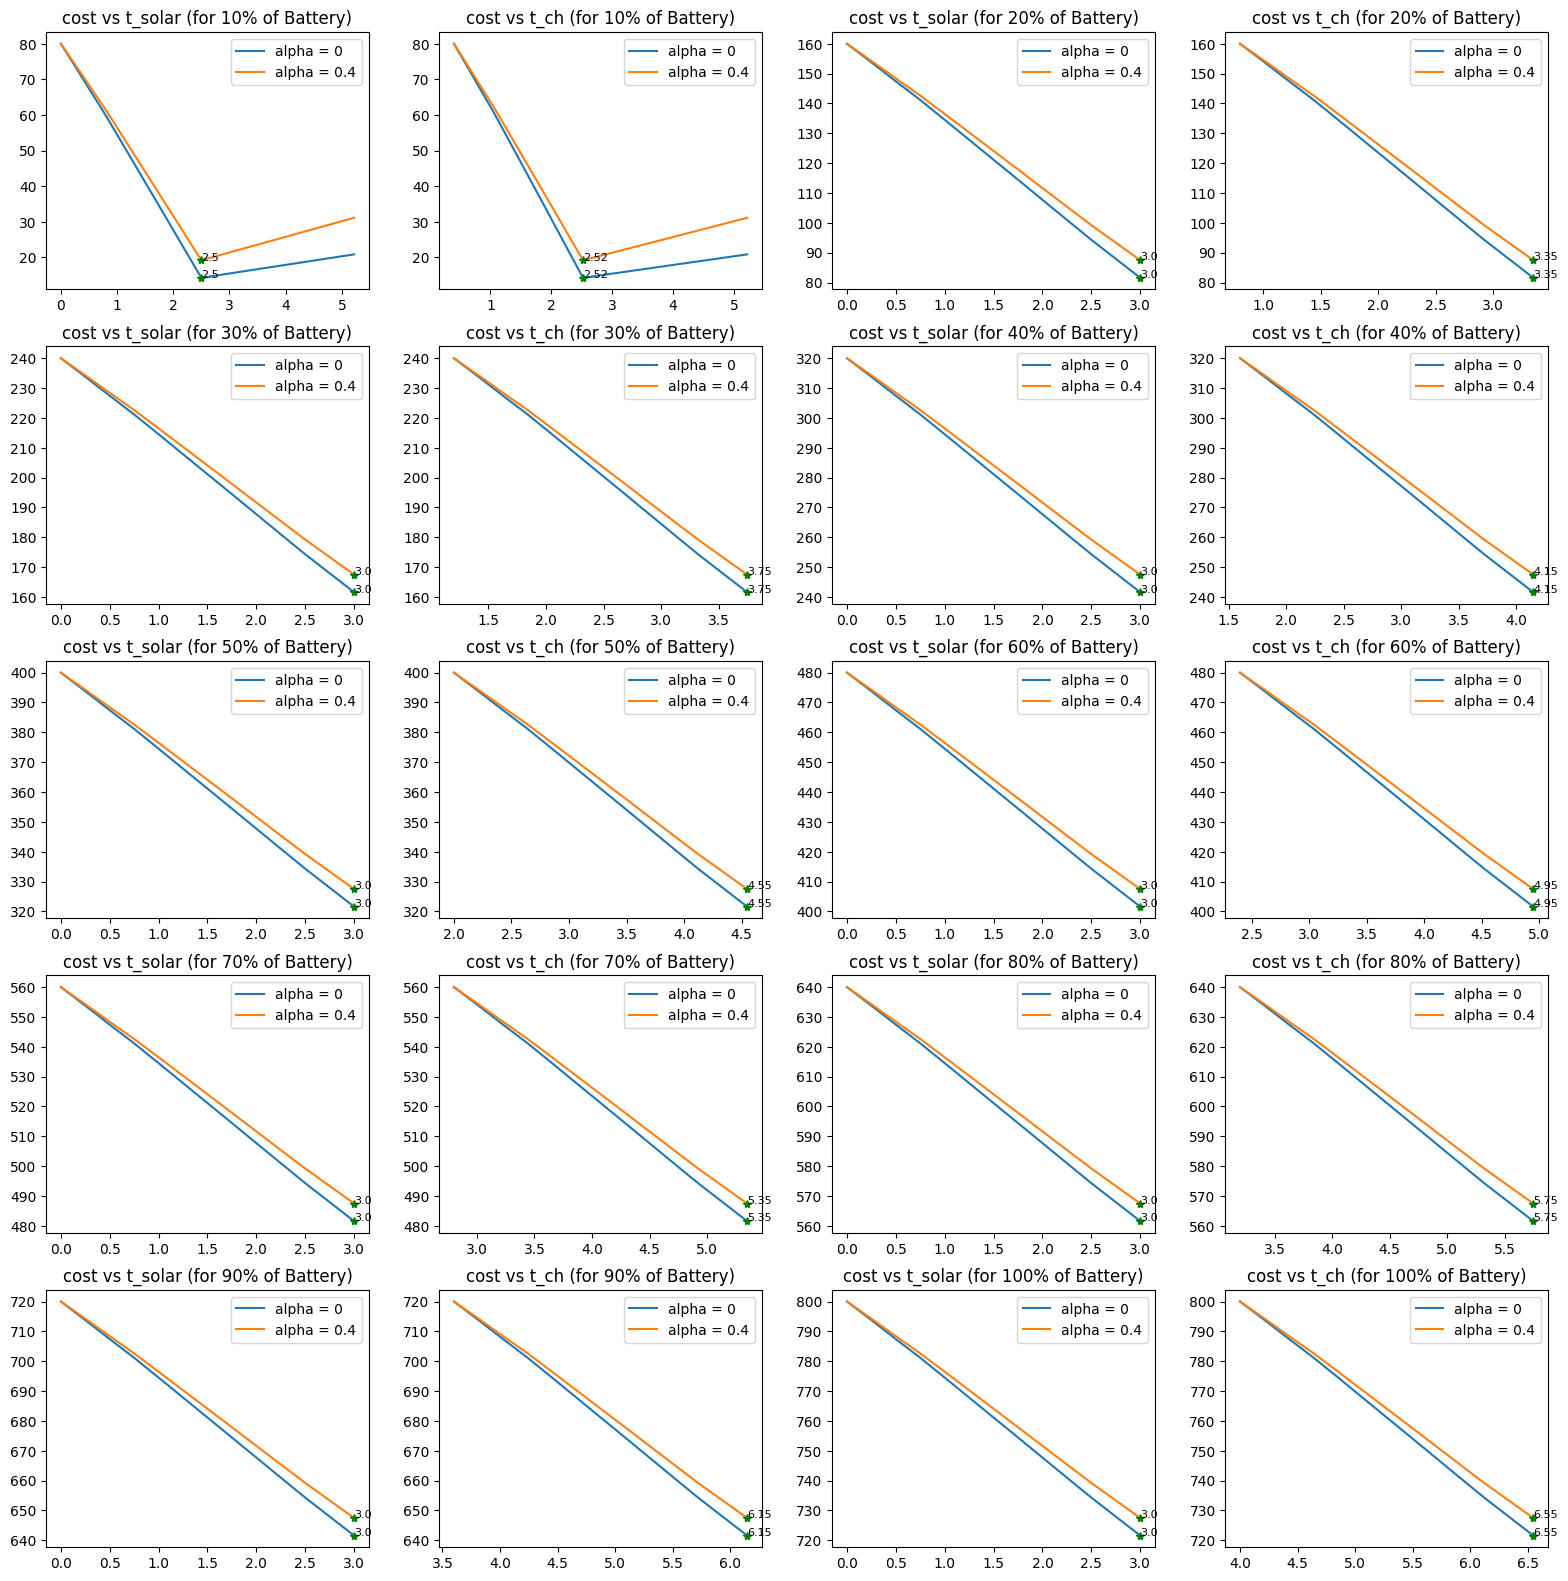

In [ ]:

api_data = API_handler()
# api_data[0][2] = 16
irr_arr, pow_arr = api_arr_maker(api_data)
c_model = cost_model(pow_arr)
c_model.cost_t_solar_plotter()
c_model.cost_calculator(alpha=0.4)

alpha = 0.0, prebooking_category = 2, priority_rating = 2
base cost = 161.59, solar charging time = 3.0, total_charging_time = 3.75
cost after rush factor = 161.59, solar charging time = 3.0, total charging time = 3.75
cost after fixed cost factor = 181.59
cost after prebooking factor = 161.59
cost after priority factor = 193.59
cost after profit factor = 212.95
FINAL COST = 212.95, SOLAR CHARGING TIME = 3.0, TOTAL CHARGING TIME = 3.75
alpha = 0.1, prebooking_category = 2, priority_rating = 2
base cost = 161.59, solar charging time = 3.0, total_charging_time = 3.75
cost after rush factor = 162.85, solar charging time = 3.0, total charging time = 3.75
cost after fixed cost factor = 182.85
cost after prebooking factor = 162.85
cost after priority factor = 194.85
cost after profit factor = 214.34
FINAL COST = 214.34, SOLAR CHARGING TIME = 3.0, TOTAL CHARGING TIME = 3.75
alpha = 0.2, prebooking_category = 2, priority_rating = 2
base cost = 161.59, solar charging time = 3.0, total_charging_

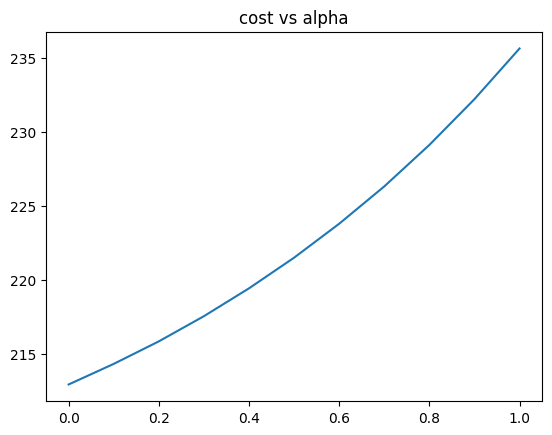

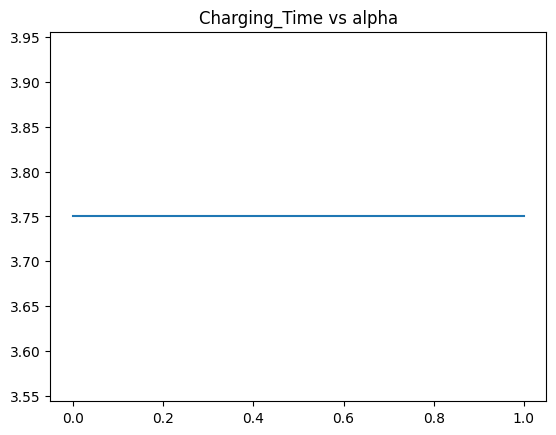

In [ ]:
alphas = np.array(range(11))/10
cost_array_alpha = []
time_array_alpha = []

for alpha in alphas:
    c_model.cost_calculator(alpha=alpha)
    cost_array_alpha.append(c_model.cost)
    time_array_alpha.append(c_model.t_ch)

plt.plot(alphas,cost_array_alpha)
plt.title('cost vs alpha')
plt.savefig('cost_alpha',dpi = 600)
plt.show()


plt.plot(alphas, time_array_alpha)
plt.title('Charging_Time vs alpha')
plt.savefig('charge_time_alpha', dpi = 600)
plt.show()